In [1]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

import pickle
import networkx as nx
import scipy.io as sio

import networkx as nx

from networkx import NetworkXException
import matplotlib.pyplot as plt

import itertools
from collections import defaultdict

import os, json
import pandas as pd

import hypernetx as hnx

import toolbag.read_write

import hyperplot

%load_ext autoreload
%autoreload 2
# %aimport hypernetx.drawing.two_column

In [2]:
os.sys.path.append("C:\\Users\\daniele\\Dropbox\\code\\O_information\\plot\\toolbag")

In [ ]:
Path("C:\\Users\\daniele\\Dropbox\\code\\O_information\\plot\\toolbag").is_dir()

In [ ]:
os.sys.path

In [ ]:
# MATLAB CODE
o= (M-2)*ent_g(X, 1);
for j=1:M
    X1=X;X1(:,j)=[];
    o=o+ent_g(X(:,j), 1)- ent_g(X1, 1);
end

o=-(M-1)*gccmi_ccc_nocopnorm(y,reshape(X0,n,m*M),Y0);
for k=1:M
    X=X0;X(:,:,k)=[];
    o=o+gccmi_ccc_nocopnorm(y,reshape(X,n,m*(M-1)),Y0);
end

gaussian copula mututal info between three continuous varuable


conditional mututal information conditioned to a third

# Functions

In [3]:
## LOAD DATA

def rawdata2data(rawdata, min_ord=3, max_ord=6):
    '''
    Input: rawdata (dict with '__header__', 'Otot', 'data' fields)
    Output: dict with Otot fields (sorted_red, index_red, bootsig_red, etc)
    '''
    
    data = {'sorted_red':{}, 'index_red':{}, 'bootsig_red':{},
        'sorted_syn':{}, 'index_syn':{}, 'bootsig_syn':{}}
    for order in range(min_ord, max_ord): 
        for key in data.keys():
            tmp = rawdata['Otot'][order - 1][key]
            
            if not hasattr(tmp, '__len__'): # convert matlab singletons to array
                tmp = np.array([tmp])

            if key=='index_syn' or key=='index_red': # VERY IMPORTANT!! matlab to python indexing
                data[key][order] = tmp - 1
            else:
                data[key][order] = tmp # python indexing
    return data

def add_datainfo2data(data, datainfo):
    '''
    Adds 'data', 'n_dims' and 'n_points' to data.
    
    Valid for 'empathy', 'eating', 'PTSD' datasets only.
    '''
    print('Adding data info...')
    data_shape = datainfo.shape
    print(f'shape: {data_shape}')
    data['data'] = datainfo
    data['n_dims'] = data_shape[1]
    data['n_points'] = data_shape[0]
    
def add_hypergraph2data(data,labels):
    '''
    Add edges, edge2vals, hypergraph, node info to data.
    
    '''
    print('Adding hypergraph info...')
    
    decomposed_edges, decomposed_edge2vals = get_decomposed_edge_and_vals(data,labels)
    nodes = list(range(1, data['n_dims'] + 1))
    hypergraphs = {stat : hyperplot.create_decomposed_hypergraph(nodes, decomposed_edges[stat]) for stat in ['syn', 'red']}
    
    data['edges'] = decomposed_edges
    data['edge2vals'] = decomposed_edge2vals
    data['nodes'] = nodes
    data['hypergraph'] = hypergraphs
    
def flip_color2node(color2nodes):
    '''
    Turns color2node into node2color dict.
    '''
    
    node2color = {}
    for color, nodes in color2nodes.items():
        for node in nodes:
            node2color[node] = color
    return node2color

def get_decomposed_edge_and_vals(data,labels):
    '''
    PARAMETERS
    ----------
    data : {'sorted_red' : {order : vals}, 'index_red' : {order : ixs},
            'sorted_syn' : {order : vals}, 'index_syn' : {order : ixs},
            'n_dims' : int, 'n_points' : int, 'data' : (n_dims, n_points)}
    
    RETURNS
    -------
    decomposed_edges : {order : tuple}
    decomposed_edge2val : {order : {edge : val}}
    '''
    # process data into
    # decomposed_edges = {red/syn : {order : list of edges}}
    # decomposed_edge2vals = {red/syn : {order : {edge : val}}}

    decomposed_edges = {'red':{}, 'syn':{}}
    decomposed_edges_v = {'red':{}, 'syn':{}}
    decomposed_edge2vals = {'red':{}, 'syn':{}}

    for stat in ['red', 'syn']:
        print(f'>>> {stat.upper()}')
        
        decomposed_ixs = data['index_' + stat]
        decomposed_vals = data['sorted_' + stat]

        # edges in the hypergraph
        print('Retrieving edges...')
        orders = data['index_' + stat].keys()
        for order in orders:
            n_dims = data['n_dims']
            
            # ATTENTION HERE: comes from matlab nchoosek function, e.g. a=nchoosek(1:53,3) (53 is n_dim, 3 is the order of multiplet)
            index2edge = list(itertools.combinations(range(1, n_dims + 1), order))
            #index2edge = list(itertools.combinations(range(n_dims), order))
            
            ixs = decomposed_ixs[order]
            print(f'Order: {order} | ixs: {ixs}')
            #decomposed_edges[stat][order] = [index2edge[ix] for ix in ixs]
            if len(ixs)>0:
                indices = np.array(index2edge, dtype=np.int32)[ixs]-1
            else:
                indices=[]
            target_labels = np.array(labels)[indices]
            decomposed_edges[stat][order] = target_labels.tolist()
            decomposed_edges_v[stat][order] = [index2edge[ix] for ix in ixs]
            #decomposed_edges[stat][order] = np.array(labels)[np.array(indexlist)[ixs]].tolist()
        # values for each edge
        print('Retrieving edge values...')
        edge2vals = {}
        for order in orders:
            
            edges = decomposed_edges_v[stat][order]
            vals = decomposed_vals[order]
            print(f'Order: {order} | vals: {vals}')
            for edge, val in zip(edges, vals):
                decomposed_edge2vals[stat][edge] = val # add order field?
                
    return decomposed_edges, decomposed_edge2vals
def get_frozenset_label(S, count=False, override={}):
    """
    Helper function for rendering the labels of possibly collapsed nodes and edges
    Parameters
    ----------
    S: iterable
        list of entities to be labeled
    count: bool
        True if labels should be counts of entities instead of list
    Returns
    -------
    dict
        mapping of entity to its string representation
    """

    def helper(v):
        if type(v) == frozenset:
            if count and len(v) > 1:
                return f"x {len(v)}"
            elif count:
                return ""
            else:
                return ", ".join([str(override.get(s, s)) for s in v])
        return str(v)

    return {v: override.get(v, helper(v)) for v in S}

# Psychological Data

**DATASETS**
- Empathy (Briganti2017): https://scholarlypublications.universiteitleiden.nl/access/item%3A2953156/view 
- Eating disorders: https://onlinelibrary.wiley.com/doi/epdf/10.1002/erv.2805
- PTSD: https://link.springer.com/article/10.3758/s13428-017-0862-1#Sec14

## Load and preprocess data

### Load rawdata

In [ ]:
 # Load .mat with O-information
dataset_dir = Path.cwd()/'data/psychological'
print('Dataset directory exists:', dataset_dir.is_dir())
datasets = ['Briganti2017','Briganti2017_groups', 'EatingDisorders', 'PTSD', 'PTSD_full']
dataset_names = ['empathy', 'empathy_groups', 'eating', 'PTSD', 'PTSD_full']

labels_tot ={}
labels_tot['empathy']=['1FS', '2EC', '3PT_R', '4EC_R', '5FS', '6PD', '7FS_R', 
   '8PT','9EC', '10PD', '11PT', '12FS_R', '13PD_R', '14EC_R', '15PT_R', 
     '16FS', '17PD', '18EC_R', '19PD_R', '20EC', '21PT', '22EC', '23FS', 
       '24PD', '25PT', '26FS', '27PD', '28PT']
labels_tot['empathy_groups']=['1FS', '2EC', '3PT_R', '4EC_R', '5FS', '6PD', '7FS_R', 
   '8PT','9EC', '10PD', '11PT', '12FS_R', '13PD_R', '14EC_R', '15PT_R', 
     '16FS', '17PD', '18EC_R', '19PD_R', '20EC', '21PT', '22EC', '23FS', 
       '24PD', '25PT', '26FS', '27PD', '28PT']
labels_tot['eating']=['Dft', 'Bul', 'Bod', 'Ine', 'Per', 'Dis', 'Awa', 'Fea', 'Asm', 'Imp', 'Soc', 'BDI',
          'Anx', 'Res', 'Nov', 'Har', 'Red', 'Pes', 'Sed', 'Coa', 'Set', 'Dir', 'Aut', 'Lim',
          'Foc', 'Inh', 'Mis', 'Sta', 'Exp', 'Cri', 'Qua', 'Pref']
labels_tot['PTSD']=['B1','B2','B3','B4','B5','C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5','E6']
labels_tot['PTSD_full']=['B1','B2','B3','B4','B5','C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5','E6','Anx','Dep','SI','PFunc','MFunc','Age','Sex']

rawdata = {dataset_names[n] : toolbag.read_write.loadmat(dataset_dir/f"{dataset}.mat") for n, dataset in enumerate(datasets)}

for name in dataset_names:
    rawdata[name]['Otot'] = [toolbag.read_write._todict(x) for x in rawdata[name]['Otot']]

In [ ]:
np.array(np.arange(0))

In [ ]:
DATA = {}
for name in dataset_names:
    print(f'DATASET: {name.upper()}')
    print(8*'=')
    DATA[name] = rawdata2data(rawdata[name])
    add_datainfo2data(DATA[name], rawdata[name]['data'])
    print(labels_tot[name])
    add_hypergraph2data(DATA[name], labels_tot[name])
    print()

In [ ]:
# for name in dataset_names:
#     print('>> DATASET:', name.upper())
#     data = DATA[name]
#     decomposed_edges, decomposed_edge2vals = get_decomposed_edge_and_vals(data)
#     nodes = list(range(1, data['n_dims'] + 1))
#     hypergraphs = {stat : hyperplot.create_decomposed_hypergraph(nodes, decomposed_edges[stat]) for stat in ['syn', 'red']}
    
#     DATA[name]['edges'] = decomposed_edges
#     DATA[name]['edge2vals'] = decomposed_edge2vals
#     DATA[name]['nodes'] = nodes
#     DATA[name]['hypergraph'] = hypergraphs

### Add color

#### Empathy

In [ ]:
labels=['1FS', '2EC', '3PT_R', '4EC_R', '5FS', '6PD', '7FS_R', 
   '8PT','9EC', '10PD', '11PT', '12FS_R', '13PD_R', '14EC_R', '15PT_R', 
     '16FS', '17PD', '18EC_R', '19PD_R', '20EC', '21PT', '22EC', '23FS', 
       '24PD', '25PT', '26FS', '27PD', '28PT']

empathy_color2labels = {'red' : [labels[0], labels[4], labels[6], labels[11], labels[15], labels[22], labels[25]],
                       'lightblue' : [labels[1], labels[3], labels[8], labels[13], labels[17], labels[19], labels[21]],
                       'blue' : [labels[5], labels[9], labels[12], labels[16], labels[18], labels[23], labels[26]],
                       'orange' :[labels[2], labels[7], labels[10], labels[14], labels[20], labels[24], labels[27]]}

nodes = [1, 5, 7, 12, 16, 23, 26,
        2, 4, 9, 14, 18, 20, 22,
        6, 10, 13, 17, 19, 24, 27,
        3, 8, 11, 15, 21, 25, 28]
nodeorder = {node:n for n, node in enumerate(nodes)}


label2colors = flip_color2node(empathy_color2labels)

node2colors = {labels.index(label) : color for label, color in label2colors.items()}

DATA['empathy']['node2colors'] = node2colors


#DATA['empathy']['node2colors'] = flip_color2node(empathy_color2labels)
#DATA['empathy']['nodeorder'] = nodeorder

In [ ]:
labels=['1FS', '2EC', '3PT_R', '4EC_R', '5FS', '6PD', '7FS_R', 
   '8PT','9EC', '10PD', '11PT', '12FS_R', '13PD_R', '14EC_R', '15PT_R', 
     '16FS', '17PD', '18EC_R', '19PD_R', '20EC', '21PT', '22EC', '23FS', 
       '24PD', '25PT', '26FS', '27PD', '28PT']

empathy_color2labels = {'red' : [labels[0], labels[4], labels[6], labels[11], labels[15], labels[22], labels[25]],
                       'lightblue' : [labels[1], labels[3], labels[8], labels[13], labels[17], labels[19], labels[21]],
                       'blue' : [labels[5], labels[9], labels[12], labels[16], labels[18], labels[23], labels[26]],
                       'orange' :[labels[2], labels[7], labels[10], labels[14], labels[20], labels[24], labels[27]]}

nodes = [1, 5, 7, 12, 16, 23, 26,
        2, 4, 9, 14, 18, 20, 22,
        6, 10, 13, 17, 19, 24, 27,
        3, 8, 11, 15, 21, 25, 28]
nodeorder = {node:n for n, node in enumerate(nodes)}


label2colors = flip_color2node(empathy_color2labels)

node2colors = {labels.index(label) : color for label, color in label2colors.items()}

DATA['empathy_groups']['node2colors'] = node2colors


#DATA['empathy']['node2colors'] = flip_color2node(empathy_color2labels)
#DATA['empathy']['nodeorder'] = nodeorder

#### Eating

In [ ]:
labels = ['Dft', 'Bul', 'Bod', 'Ine', 'Per', 'Dis', 'Awa', 'Fea', 'Asm', 'Imp', 'Soc', 'BDI',
          'Anx', 'Res', 'Nov', 'Har', 'Red', 'Pes', 'Sed', 'Coa', 'Set', 'Dir', 'Aut', 'Lim',
          'Foc', 'Inh', 'Mis', 'Sta', 'Exp', 'Cri', 'Qua', 'Pref']

eating_color2labels = {'#7bba72' : ['Mis', 'Qua', 'Pref', 'Sta', 'Cri', 'Exp'],
                       '#ad9a53' : ['Soc', 'Asm', 'Imp', 'Per', 'Bod', 'Dft', 'Ine', 'Bul',
                            'Dis', 'Awa', 'Fea'],
                        '#789cff' : ['Sed', 'Har', 'Pes', 'Nov', 'Coa', 'Red', 'Set'],
                      '#d78adb' : ['Aut', 'Inh', 'Dir', 'Lim', 'Foc'],
                       '#cf5540' : ['BDI'],
                       '#48c0c2' : ['Anx', 'Res']}

label2colors = flip_color2node(eating_color2labels)

node2colors = {labels.index(label) : color for label, color in label2colors.items()}

DATA['eating']['node2colors'] = node2colors

#### PTSD

In [ ]:
labels = ['B1','B2','B3','B4','B5','C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5','E6']
#bbbbbb','#a8e6cf', '#dcedc1', '#ffd3b6', '#ff8b94'
eating_color2labels = {'#a8e6cf' : ['B1','B2','B3','B4','B5'],
                        '#dcedc1' : ['C1', 'C2'],
                      '#ffd3b6' : [ 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'],
                       '#ff8b94' : ['E1', 'E2', 'E3', 'E4', 'E5','E6']}

label2colors = flip_color2node(eating_color2labels)

node2colors = {labels.index(label) : color for label, color in label2colors.items()}

DATA['PTSD']['node2colors'] = node2colors
DATA['PTSD']['labels'] = labels

#### PTSD_full

In [ ]:
labels = ['B1','B2','B3','B4','B5','C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5','E6','Anx','Dep','SI','PFunc','MFunc','Age','Sex']
#bbbbbb','#a8e6cf', '#dcedc1', '#ffd3b6', '#ff8b94'
eating_color2labels = {'#bbbbbb' :['Anx','Dep','SI','PFunc','MFunc','Age','Sex'],
                        '#a8e6cf' : ['B1','B2','B3','B4','B5'],
                        '#dcedc1' : ['C1', 'C2'],
                      '#ffd3b6' : [ 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'],
                       '#ff8b94' : ['E1', 'E2', 'E3', 'E4', 'E5','E6']}

label2colors = flip_color2node(eating_color2labels)

node2colors = {labels.index(label) : color for label, color in label2colors.items()}

DATA['PTSD_full']['node2colors'] = node2colors
DATA['PTSD_full']['labels'] = labels

## Plot Eating Dataset

In [ ]:
savefig = True
dataset = 'eating'
data = DATA[dataset]
labels = labels_tot[dataset]
nodecolor = DATA[dataset]['node2colors']
nodeorder = None

### Two column Plot

In [ ]:
hyperplot.plot_hypergraph_two_columns(data['edges']['red'], labels, nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_red.png", dpi=300)

hyperplot.plot_hypergraph_two_columns(data['edges']['syn'], labels, nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_syn.png", dpi=300)

### Hypergraph Plot

In [ ]:
import inspect
print(os.path.abspath(inspect.getfile(hnx.drawing.draw)))
print(os.path.abspath(inspect.getfile(hyperplot.plot_hypergraph_areas)))
print(os.path.abspath(inspect.getfile(hyperplot.plot_hypergraph_two_columns)))

In [ ]:
hyperplot.plot_hypergraph_areas(data['edges']['red'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_red.png", dpi=300)

hyperplot.plot_hypergraph_areas(data['edges']['syn'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_syn.png", dpi=300)

## Plot Empathy Dataset

In [ ]:
savefig = True
dataset = 'empathy'
data = DATA[dataset]
labels = labels_tot[dataset]
nodecolor = DATA[dataset]['node2colors']
nodeorder = None
print(nodecolor)

### Two column Plot

In [ ]:
print(Path.cwd()/f"figures/)

In [ ]:
hyperplot.plot_hypergraph_two_columns(data['edges']['red'], labels, nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_red.png", dpi=300)

hyperplot.plot_hypergraph_two_columns(data['edges']['syn'], labels, nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_syn.png", dpi=300)

### Hypergraph Plot

In [ ]:
hyperplot.plot_hypergraph_areas(data['edges']['red'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_red.png", dpi=300)

hyperplot.plot_hypergraph_areas(data['edges']['syn'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_syn.png", dpi=300)

## Plot PTSD full Dataset


In [ ]:
savefig = True
dataset = 'PTSD_full'
data = DATA[dataset]
labels = labels_tot[dataset]
nodecolor = DATA[dataset]['node2colors']
nodeorder = None

### Two column plot

In [ ]:
hyperplot.plot_hypergraph_two_columns(data['edges']['red'], data['labels'], nodecolor=nodecolor, nodeorder=nodeorder,column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_red.png", dpi=300)

hyperplot.plot_hypergraph_two_columns(data['edges']['syn'], data['labels'], nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_syn.png", dpi=300)

### Hypergraph plot

In [ ]:
hyperplot.plot_hypergraph_areas(data['edges']['red'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_red.png", dpi=300)

hyperplot.plot_hypergraph_areas(data['edges']['syn'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_syn.png", dpi=300)

## Plot PTSD Dataset


In [ ]:
savefig = True
dataset = 'PTSD'
data = DATA[dataset]
labels = labels_tot[dataset]
nodecolor = DATA[dataset]['node2colors']
nodeorder = None

### Two column plot

In [ ]:
hyperplot.plot_hypergraph_two_columns(data['edges']['red'], data['labels'], nodecolor=nodecolor, nodeorder=nodeorder,column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_red.png", dpi=300)

hyperplot.plot_hypergraph_two_columns(data['edges']['syn'], data['labels'], nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=12)
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_syn.png", dpi=300)

### Hypergraph plot

In [ ]:
hyperplot.plot_hypergraph_areas(data['edges']['red'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_red.png", dpi=300)

hyperplot.plot_hypergraph_areas(data['edges']['syn'], labels, edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_syn.png", dpi=300)

# Simulated Data

some simulated data to plot, in this case the order goes only to 4 since the simulation only involves triplets.

## Load and preprocess data

### Load rawdata

In [19]:
 # Load .mat with O-information
dataset_dir = Path.cwd()/'data/simulated'
print('Dataset directory exists:', dataset_dir.is_dir())
datasets = ['Ex1_zero','Ex1_red','Ex1_syn',
            'Ex2_zero','Ex2_red','Ex2_syn','Ex2_strongsyn',
            'Ex2_zero_strongC','Ex2_red_strongC','Ex2_syn_strongC','Ex2_strongsyn_strongC',
            'Ex3_zero','Ex3_red','Ex3_syn',
            'Ex6_zero','Ex6_red','Ex6_syn','HG_0']
dataset_names = ['independent triplets, independent interaction',
                 'independent triplets, redundancy',
                 'independent triplets, synergy',
                 '3 linked triplets zz, independent interaction',
                 '3 linked triplets zz, redundancy',
                 '3 linked triplets zz, synergy',
                 '3 linked triplets zz, strong synergy',
                 '3 strongly linked triplets zz, independent interaction',
                 '3 strongly linked triplets zz, redundancy',
                 '3 strongly linked triplets zz, synergy',
                 '3 strongly linked triplets zz, strong synergy',
                 '3 linked triplets yz, independent interaction',
                 '3 linked triplets yz, redundancy',
                 '3 linked triplets yz, synergy',
                 '4 linked triplets zz, independent interaction',
                 '4 linked triplets zz, redundancy',
                 '4 linked triplets zz, synergy',
                 'redundancy Golino case 0']
rawdata = {dataset_names[n] : toolbag.read_write.loadmat(dataset_dir/f"{dataset}.mat") for n, dataset in enumerate(datasets)}

for name in dataset_names:
    rawdata[name]['Otot'] = [toolbag.read_write._todict(x) for x in rawdata[name]['Otot']]

labels_tot ={}
for name in dataset_names:
    a=('4' in name)
    b=('Golino' in name)
    if a:
        labels_tot[name]=['Ax','Ay','Az','Bx','By','Bz','Cx','Cy','Cz','Dx','Dy','Dz',
                      'Ex','Ey','Ex','Fx','Fy','Fz','Gx','Gy','Gz','Hx','Hy','Hz','Ix','Iy','Iz',
                     'Jx','Jy','Jz','Kx','Ky','Kz','Lx','Ly','Lz']
    elif b: 
        labels_tot[name]=['V1','V2','V3','V4','V5','V6','V7','V8','V9']
    else:
        labels_tot[name]=['Ax','Ay','Az','Bx','By','Bz','Cx','Cy','Cz','Dx','Dy','Dz',
                      'Ex','Ey','Ex','Fx','Fy','Fz','Gx','Gy','Gz','Hx','Hy','Hz','Ix','Iy','Iz']

Dataset directory exists: True


### Preprocess data

In [20]:
DATA = {}
for name in dataset_names:
    print(f'DATASET: {name.upper()}')
    print(8*'=')
    DATA[name] = rawdata2data(rawdata[name])
    add_datainfo2data(DATA[name], rawdata[name]['data'])
    print(labels_tot[name])
    add_hypergraph2data(DATA[name], labels_tot[name])
    print()

DATASET: INDEPENDENT TRIPLETS, INDEPENDENT INTERACTION
Adding data info...
shape: (2000, 27)
['Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'Cx', 'Cy', 'Cz', 'Dx', 'Dy', 'Dz', 'Ex', 'Ey', 'Ex', 'Fx', 'Fy', 'Fz', 'Gx', 'Gy', 'Gz', 'Hx', 'Hy', 'Hz', 'Ix', 'Iy', 'Iz']
Adding hypergraph info...
>>> RED
Retrieving edges...
Order: 3 | ixs: []
Order: 4 | ixs: []
Order: 5 | ixs: []
Retrieving edge values...
Order: 3 | vals: []
Order: 4 | vals: []
Order: 5 | vals: []
>>> SYN
Retrieving edges...
Order: 3 | ixs: []
Order: 4 | ixs: []
Order: 5 | ixs: []
Retrieving edge values...
Order: 3 | vals: []
Order: 4 | vals: []
Order: 5 | vals: []

DATASET: INDEPENDENT TRIPLETS, REDUNDANCY
Adding data info...
shape: (2000, 27)
['Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'Cx', 'Cy', 'Cz', 'Dx', 'Dy', 'Dz', 'Ex', 'Ey', 'Ex', 'Fx', 'Fy', 'Fz', 'Gx', 'Gy', 'Gz', 'Hx', 'Hy', 'Hz', 'Ix', 'Iy', 'Iz']
Adding hypergraph info...
>>> RED
Retrieving edges...
Order: 3 | ixs: [2841 2470  901    0 2905 1595 2924 2705 2109]
Order: 4 | ixs:

Order: 4 | ixs: [14495 14950 17479]
Order: 5 | ixs: []
Retrieving edge values...
Order: 3 | vals: [-0.20705632 -0.20195323 -0.20142269 -0.0891908  -0.07147018 -0.06548086
 -0.05769593 -0.05258288 -0.0482473  -0.02115838 -0.0086207  -0.00566317]
Order: 4 | vals: [-0.23466893 -0.12573949 -0.08846548]
Order: 5 | vals: []

DATASET: 3 LINKED TRIPLETS YZ, INDEPENDENT INTERACTION
Adding data info...
shape: (2000, 27)
['Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'Cx', 'Cy', 'Cz', 'Dx', 'Dy', 'Dz', 'Ex', 'Ey', 'Ex', 'Fx', 'Fy', 'Fz', 'Gx', 'Gy', 'Gz', 'Hx', 'Hy', 'Hz', 'Ix', 'Iy', 'Iz']
Adding hypergraph info...
>>> RED
Retrieving edges...
Order: 3 | ixs: []
Order: 4 | ixs: []
Order: 5 | ixs: []
Retrieving edge values...
Order: 3 | vals: []
Order: 4 | vals: []
Order: 5 | vals: []
>>> SYN
Retrieving edges...
Order: 3 | ixs: [   6 2404  691  625 2115 2876]
Order: 4 | ixs: []
Order: 5 | ixs: []
Retrieving edge values...
Order: 3 | vals: [-0.01562531 -0.01370151 -0.00970721 -0.00945521 -0.00823986 -0.00522

### Add color

In [6]:
from pylab import *

cmap = cm.get_cmap('Paired', 12)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#a6cee3
#1f78b4
#b2df8a
#33a02c
#fb9a99
#e31a1c
#fdbf6f
#ff7f00
#cab2d6
#6a3d9a
#ffff99
#b15928


### Labels and colors

In [21]:
labels_3=['Ax','Ay','Az','Bx','By','Bz','Cx','Cy','Cz','Dx','Dy','Dz',
                      'Ex','Ey','Ex','Fx','Fy','Fz','Gx','Gy','Gz','Hx','Hy','Hz','Ix','Iy','Iz']
triplets_color2labels_3 = {'#a6cee3' : labels_3[0:3],
                       '#1f78b4' : labels_3[3:6],
                       '#b2df8a' : labels_3[6:9],
                       '#33a02c' : labels_3[9:12],
                       '#fb9a99' : labels_3[12:15],
                       '#e31a1c' : labels_3[15:18],
                       '#fdbf6f' : labels_3[18:21],
                       '#ff7f00' : labels_3[21:24],
                       '#cab2d6' : labels_3[24:27]}

labels_4=['Ax','Ay','Az','Bx','By','Bz','Cx','Cy','Cz','Dx','Dy','Dz',
                      'Ex','Ey','Ex','Fx','Fy','Fz','Gx','Gy','Gz','Hx','Hy','Hz','Ix','Iy','Iz',
                     'Jx','Jy','Jz','Kx','Ky','Kz','Lx','Ly','Lz']
triplets_color2labels_4 = {'#a6cee3' : labels_4[0:3],
                       '#1f78b4' : labels_4[3:6],
                       '#b2df8a' : labels_4[6:9],
                       '#33a02c' : labels_4[9:12],
                       '#fb9a99' : labels_4[12:15],
                       '#e31a1c' : labels_4[15:18],
                       '#fdbf6f' : labels_4[18:21],
                       '#ff7f00' : labels_4[21:24],
                       '#cab2d6' : labels_4[24:27],
                       '#6a3d9a' : labels_4[27:30],
                       '#ffff99' : labels_4[30:33],
                       '#b15928' : labels_4[33:36]}  

labels_HG=['V1','V2','V3','V4','V5','V6','V7','V8','V9']
triplets_color2labels_HG = {'#a6cee3' : labels_HG[0:3],
                       '#1f78b4' : labels_HG[3:6],
                       '#b2df8a' : labels_HG[6:9]}


for name in dataset_names:
    print(f'DATASET: {name.upper()}')
    print(8*'=')
    a=('4' in name)
    b=('Golino' in name)
    if a:
        label2colors = flip_color2node(triplets_color2labels_4)
        node2colors = {labels_4.index(label) : color for label, color in label2colors.items()}
        DATA[name]['node2colors'] = node2colors
        DATA[name]['labels'] = labels_4
    elif b:
        label2colors = flip_color2node(triplets_color2labels_HG)
        node2colors = {labels_HG.index(label) : color for label, color in label2colors.items()}
        DATA[name]['node2colors'] = node2colors
        DATA[name]['labels'] = labels_HG
    else:
        label2colors = flip_color2node(triplets_color2labels_3)
        node2colors = {labels_3.index(label) : color for label, color in label2colors.items()}
        DATA[name]['node2colors'] = node2colors
        DATA[name]['labels'] = labels_3

DATASET: INDEPENDENT TRIPLETS, INDEPENDENT INTERACTION
DATASET: INDEPENDENT TRIPLETS, REDUNDANCY
DATASET: INDEPENDENT TRIPLETS, SYNERGY
DATASET: 3 LINKED TRIPLETS ZZ, INDEPENDENT INTERACTION
DATASET: 3 LINKED TRIPLETS ZZ, REDUNDANCY
DATASET: 3 LINKED TRIPLETS ZZ, SYNERGY
DATASET: 3 LINKED TRIPLETS ZZ, STRONG SYNERGY
DATASET: 3 STRONGLY LINKED TRIPLETS ZZ, INDEPENDENT INTERACTION
DATASET: 3 STRONGLY LINKED TRIPLETS ZZ, REDUNDANCY
DATASET: 3 STRONGLY LINKED TRIPLETS ZZ, SYNERGY
DATASET: 3 STRONGLY LINKED TRIPLETS ZZ, STRONG SYNERGY
DATASET: 3 LINKED TRIPLETS YZ, INDEPENDENT INTERACTION
DATASET: 3 LINKED TRIPLETS YZ, REDUNDANCY
DATASET: 3 LINKED TRIPLETS YZ, SYNERGY
DATASET: 4 LINKED TRIPLETS ZZ, INDEPENDENT INTERACTION
DATASET: 4 LINKED TRIPLETS ZZ, REDUNDANCY
DATASET: 4 LINKED TRIPLETS ZZ, SYNERGY
DATASET: REDUNDANCY GOLINO CASE 0


## Plot

In [22]:
#dataset_names = ['independent triplets, independent interaction',
#                 'independent triplets, redundancy',
#                 'independent triplets, synergy',
#                 '3 linked triplets zz, independent interaction',
#                 '3 linked triplets zz, redundancy',
#                 '3 linked triplets zz, synergy',
#                 '3 linked triplets zz, strong synergy',
#                 '3 strongly linked triplets zz, independent interaction',
#                 '3 strongly linked triplets zz, redundancy',
#                 '3 strongly linked triplets zz, synergy',
#                 '3 strongly linked triplets zz, strong synergy',
#                 '3 linked triplets yz, independent interaction',
#                 '3 linked triplets yz, redundancy',
#                 '3 linked triplets yz, synergy',
#                 '4 linked triplets zz, independent interaction',
#                 '4 linked triplets zz, redundancy',
#                 '4 linked triplets zz, synergy']

savefig = True
dataset = 'redundancy Golino case 0'
#DATA[dataset]['node2colors'] = flip_color2node(triplets_color2nodes)
#DATA[dataset]['nodeorder'] = nodeorder
data = DATA[dataset]
nodecolor = DATA[dataset]['node2colors']
nodeorder = None

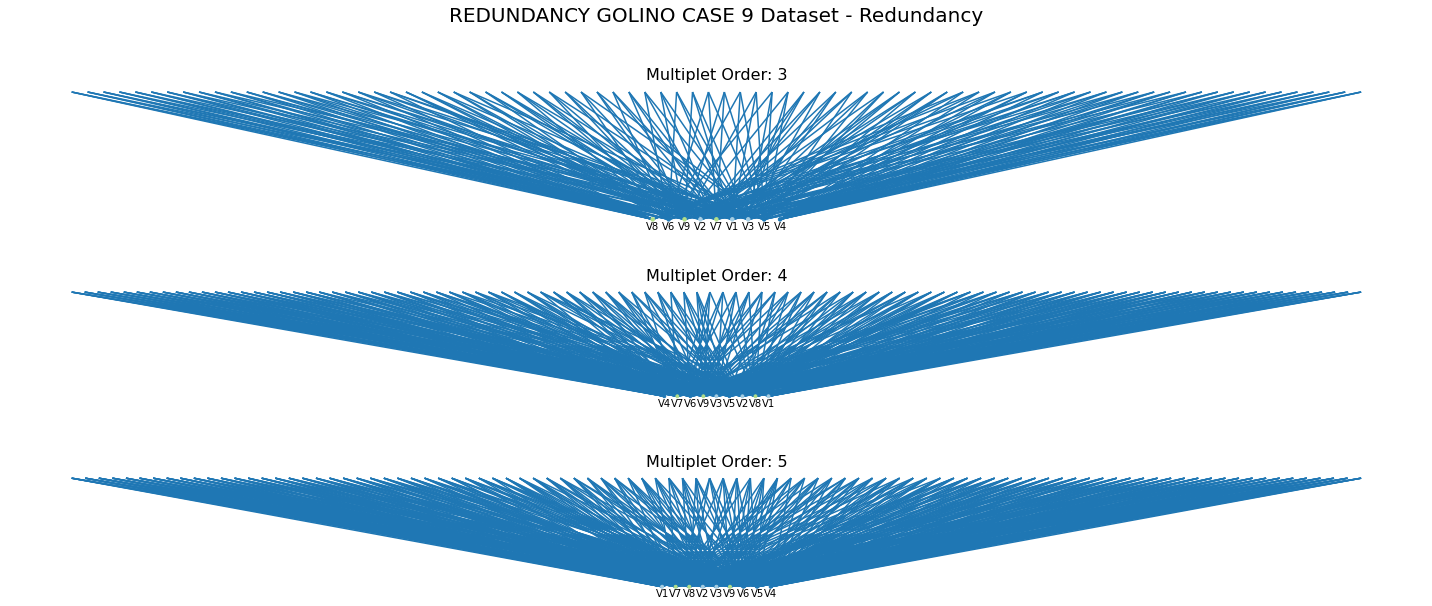

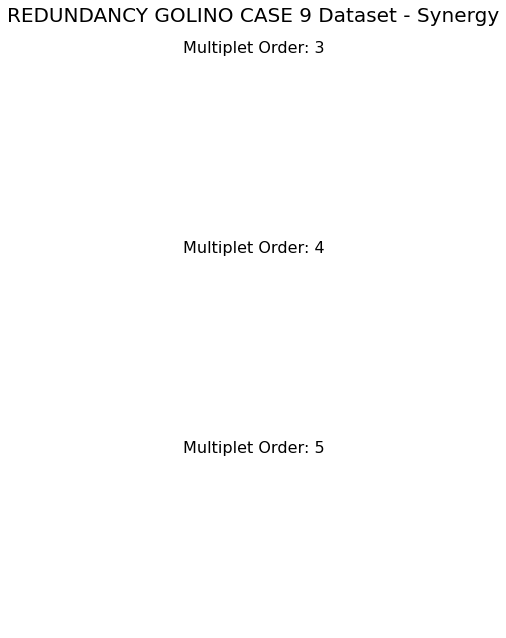

In [16]:
hyperplot.plot_hypergraph_two_columns(data['edges']['red'], data['labels'], nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=8, nodesize=0.11, subplot_width=20)
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_red.png", dpi=300)

hyperplot.plot_hypergraph_two_columns(data['edges']['syn'], data['labels'], nodecolor=nodecolor, nodeorder=nodeorder, column_spacing=2.5, nodesize=0.11, subplot_width=20)
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)
plt.subplots_adjust(top=0.9)
if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_twocolumn_syn.png", dpi=300)

Order 4 has no edges.
Order 5 has no edges.
Order 3 has no edges.
Order 4 has no edges.
Order 5 has no edges.


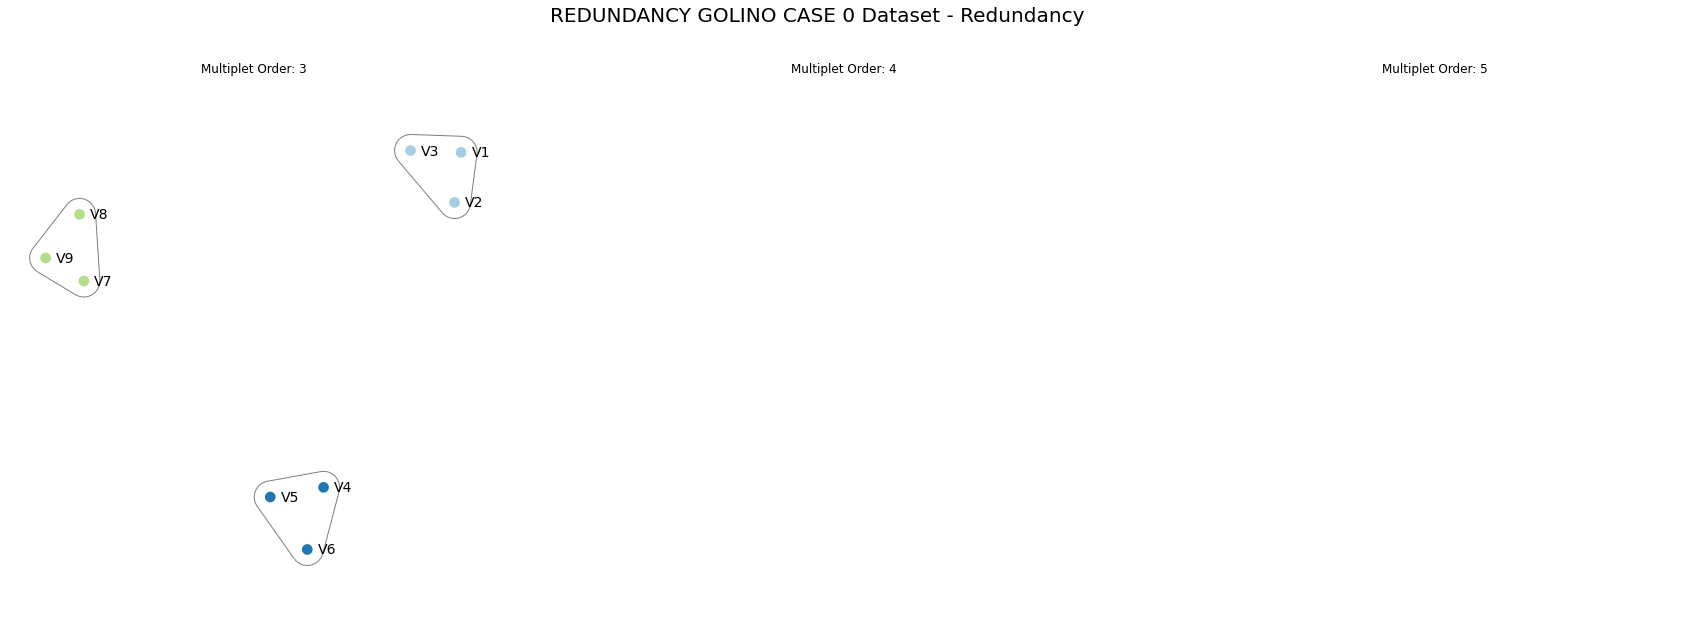

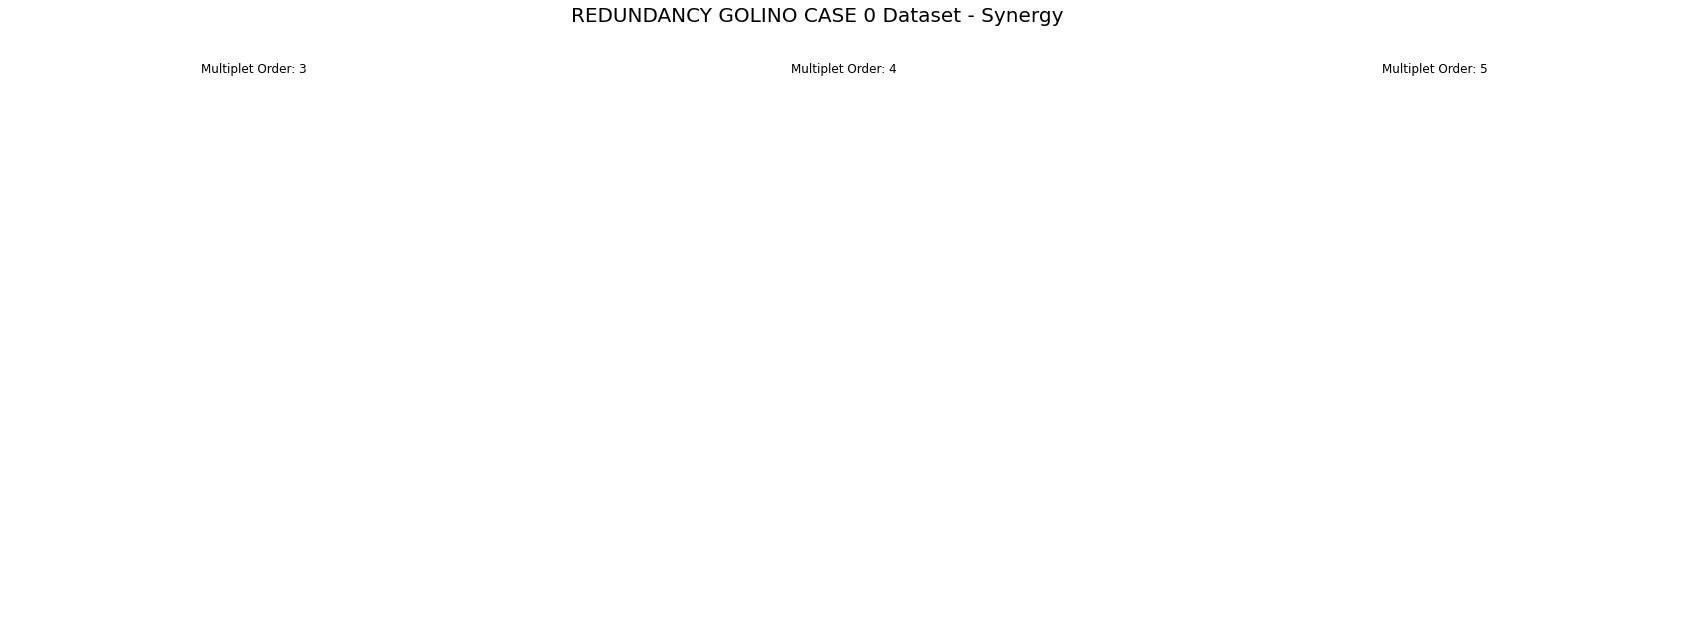

In [23]:
hyperplot.plot_hypergraph_areas(data['edges']['red'], data['labels'], edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Redundancy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_red.png", dpi=300)

hyperplot.plot_hypergraph_areas(data['edges']['syn'], data['labels'], edgecolor='gray', nodecolor=nodecolor, )
plt.suptitle(f'{dataset.upper()} Dataset - Synergy', fontsize=20)

if savefig: plt.savefig(Path.cwd()/f"figures/{dataset}_areas_syn.png", dpi=300)